# MSCA 31009 Final Project
### Author: Rajat Nagar, Yifan Gao
### Date:  August 26, 2021

## 1. Prep work

### 1a. Import necessary libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")
import os, sys
from os.path import join, split, isdir, isfile, splitext, split, abspath, dirname
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import shutil
import time
import datetime
import torch
from torch.utils import data
import torch.nn as nn
import torch.autograd.variable as Variable
import scipy.io as sio
from torch.nn.modules.conv import _ConvNd
from torch.nn.modules.conv import _single, _pair, _triple
from torch.optim.optimizer import Optimizer, required
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, sampler, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
import matplotlib
import matplotlib.pyplot as plt
import random

### 1b. Download data & Set up folders & parameters

Download dataset containing test images, train images, train labels (sketch/edge of train image) and lst files (path of train and test images) from this link: https://mftp.mmcheng.net/liuyun/rcf/data/HED-BSDS.tar.gz , and extract the dataset to ROOT_DIR/data/ folder

Download dataset containg test labels from this link: http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz Unzip the package and extract .mat files from BSR_bsds500.tgz\BSR\BSDS500\data\groundTruth\test\ to gt/ folder

If you run this notebook in Linux environment, run command wget http://mftp.mmcheng.net/liuyun/rcf/data/HED-BSDS.tar.gz

Download supporting package for OIS/ODS calculation from this link: https://github.com/Walstruzz/edge_eval_python/archive/refs/heads/main.zip Unzip the package, extract cxx folder to ROOT_DIR, and extract bwmorph_thin.py, correspond_pixels.py, edges_eval_dir.py from impl folder to ROOT_DIR.\
Open edges_eval_dir.py and modify import script "from .bwmorph_thin import bwmorph_thin from .correspond_pixels import correspond_pixels" to "from bwmorph_thin import bwmorph_thin from correspond_pixels import correspond_pixels".\
Note the files in cxx folder are only executable in Linux/Unix environment. They do not work in Windows. If do not have access to Linux/Unix, comment out the chunk code below under "Measure model performance". To compile cxx library, run command below when you use this notebook first time:

cd cxx/src\
source build.sh

Download the vgg16 pretrained backbone model from this link: https://drive.google.com/file/d/1lUhPKKj-BSOH7yQL0mOIavvrUbjydPp5/view?usp=sharing, and extract the model to ROOT_DIR folder

Create a tmp/RCF folder under ROOT_DIR (if you do not create the code below will automatically create)

Below is the project structure. The list files contains the path for test image, and train image and label. The gt folder contains the ground true labels for test images. The train folder has 6 folders. aug_data folders contain images we are trying to sketch/apply edge detection. aug_gt folders contain train labels, which in this project are the sketches of train images drawn by humans.

In [2]:
# Define folder/path/file variables
Root_dir = '/home/ygao26/Desktop/final'
# Root_dir = 'C:/Users/mars_/Documents/Personal Document/MSCA classes/MSCA 31009 1 Machine Learning Predictive Analytics/Final/'
tmp_folder = 'tmpRCF/RCF' # tmp folder
data_folder = 'data/HED-BSDS' # root folder of dataset
test_lst = 'data/HED-BSDS/test.lst'
test_lst = join(Root_dir, test_lst) # test lst file
test_gt = join(Root_dir, 'data/HED-BSDS/gt/') # gt folder for test images
test_pre = join(Root_dir, 'tmpRCF/RCF/epoch-10-testing-record-black') # predicted test sketches; modify accordingly
tmp_dir = join(Root_dir, tmp_folder) # tmp directory
if not isdir(tmp_dir):
    os.makedirs(tmp_dir)

In [3]:
# Default parameters
dft_eta = 127.5 # eta threshold to determine whether edge will be annotated
dft_lambda = 1.1 # lambda to balance the number of positive and negative samples
dft_bs = 1 # batch size
dft_lr = 1e-6 # initial learning_rate
dft_mmtum = 0.9 # momentum
dft_wd = 2e-4 # default weight decay
dft_ss = 3 # learning rate step size
dft_gm = 0.1 # learning rate decay parameter: Gamma
dft_maxep = 11 # end epoch number (# of epochs = end epoch number - start epoch number)
dft_is = 30 # iter size
dft_step = 1 # start epoch number (useful on restarts)
dft_freq = 1000 # print frequency
dft_gpu = '0' # GPU ID
dft_tmp = tmp_folder # 'tmp folder'
dft_datap = data_folder # root folder of dataset

# enable environment for GPU use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = dft_gpu

## 2. Define BSDS Data Loader tool

In [4]:
# Convert image to PIL format
def prepare_image_PIL(im):
    im = im[:,:,::-1] - np.zeros_like(im) # rgb to bgr
    im -= np.array((104.00698793,116.66876762,122.67891434))
    im = np.transpose(im, (2, 0, 1)) # (H x W x C) to (C x H x W)
    return im

# Convert image to CV2 format
def prepare_image_cv2(im):
    im -= np.array((104.00698793,116.66876762,122.67891434))
    im = np.transpose(im, (2, 0, 1)) # (H x W x C) to (C x H x W)
    return im


class BSDS_Dataloader(data.Dataset):
    """
    Dataloader BSDS500
    """
    def __init__(self, root=data_folder, split='train', transform=False):
        self.root = root
        self.split = split
        self.transform = transform
        if self.split == 'train':
            self.filelist = join(self.root, 'train_pair.lst')
        elif self.split == 'test':
            self.filelist = join(self.root, 'test.lst')
        else:
            raise ValueError("Invalid split type!")
        # loop thru whole list of images and labels
        with open(self.filelist, 'r') as f:
            self.filelist = f.readlines()

    def __len__(self):
        return len(self.filelist)
    
    def __getitem__(self, index):
        if self.split == "train":
            # Split train images and labels
            img_file, lb_file = self.filelist[index].split()
            # Convert label sketch to tensor
            lb = np.array(Image.open(join(self.root, lb_file)), dtype=np.float32)
            # Need to squeeze label tensor to 2d from 3d
            if lb.ndim == 3:
                lb = np.squeeze(lb[:, :, 0])
            assert lb.ndim == 2
            # Add new dimension for label tensor
            lb = lb[np.newaxis, :, :]
            # Mask label values in a way to fit the implementation of proposed loss function
            # 0 means no annotator labeled at this pixel
            # 1 means all annotators have labeled at this pixel
            # 2 means ambiguous and we need to drop
            lb[lb == 0] = 0
            lb[np.logical_and(lb>0, lb<dft_eta)] = 2
            lb[lb >= dft_eta] = 1
        else:
            # get test image path
            img_file = self.filelist[index].rstrip()

        if self.split == "train":
            # Convert image to CV2 format if it's train
            img = np.array(cv2.imread(join(self.root, img_file)), dtype=np.float32)
            img = prepare_image_cv2(img)
            return img, lb
        else:
            # Convert image to PIL format if it's test
            img = np.array(Image.open(join(self.root, img_file)), dtype=np.float32)
            img = prepare_image_PIL(img)
            return img

## 3. Define utility functions

In [5]:
# This function uses bilinear interpolation to resize
# image to a higher resolution one
def make_bilinear_weights(size, num_channels):
    ''' Make a 2D bilinear kernel suitable for upsampling
    Stack the bilinear kernel for application to tensor,
    using Bilinear Interpolation'''
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    ## Interpolation calculation
    filt = (1 - abs(og[0] - center) / factor) * \
             (1 - abs(og[1] - center) / factor)
    filt = torch.from_numpy(filt)
    w = torch.zeros(num_channels, num_channels, size, size)
    for i in range(num_channels):
        w[i, i] = filt
    return w


def crop(variable, th, tw):
    ''' Crop the image to the desire dimension'''
    h, w = variable.shape[2], variable.shape[3]
    x1 = int(round((w - tw) / 2.))
    y1 = int(round((h - th) / 2.))
    return variable[:, :, y1 : y1 + th, x1 : x1 + tw]

    
def cross_entropy_loss_RCF(prediction, label):
    ''' RCF cross entropy loss function:
    prediction: predicted sketch tensor
    label: ground truth tensor'''
    label = label.long()
    mask = label.float()
    # Calculate number of positive/negative samples from ground truth
    num_positive = torch.sum((mask==1).float()).float()
    num_negative = torch.sum((mask==0).float()).float()
    # Update mask, which is weight tensor for cross entropy function
    mask[mask == 1] = 1.0 * num_negative / (num_positive + num_negative)
    mask[mask == 0] = dft_lambda * num_positive / (num_positive + num_negative)
    mask[mask == 2] = 0
    # cross entropy function
    cost = torch.nn.functional.binary_cross_entropy(
            prediction.float(),label.float(), weight=mask, reduce=False)
    return torch.sum(cost)

class Logger(object):
    ''' Update logs related to the model'''
    def __init__(self, fpath=None):
        self.console = sys.stdout
        self.file = None
        if fpath is not None:
            self.file = open(fpath, 'w')

    def __del__(self):
        self.close()

    def __enter__(self):
        pass

    def __exit__(self, *args):
        self.close()

    def write(self, msg):
        self.console.write(msg)
        if self.file is not None:
            self.file.write(msg)

    def flush(self):
        self.console.flush()
        if self.file is not None:
            self.file.flush()
            os.fsync(self.file.fileno())

    def close(self):
        self.console.close()
        if self.file is not None:
            self.file.close()

class Averagvalue(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def save_checkpoint(state, filename='checkpoint.pth'):
    """Save pre-trained models per epoch"""
    torch.save(state, filename)


def load_vgg16pretrain(model, vggmodel='vgg16convs.mat'):
    """Update weights and bias of vgg 16 model to RCF
    model as initial weights and bias, since vgg 16 
    is the backbone of RCF"""
    vgg16 = sio.loadmat(vggmodel)
    torch_params =  model.state_dict()
    for k in vgg16.keys():
        name_par = k.split('-')
        size = len(name_par)
        # Update when there is a CNN layer
        if size  == 2:
            name_space = name_par[0] + '.' + name_par[1]
            data = np.squeeze(vgg16[k])
            torch_params[name_space] = torch.from_numpy(data)
    model.load_state_dict(torch_params)

def load_vgg19pretrain(model):
    """Update weights and bias of vgg 19 model to RCF
    model as initial weights and bias, since vgg 19 
    is the backbone of RCF"""
    vgg19 = torchvision.models.vgg19(pretrained=True)
    torch_params =  model.state_dict()
    vgg19_keys = ['conv1_1','relu','conv1_2','relu','maxpool','conv2_1','relu','conv2_2','relu','maxpool',
                  'conv3_1','relu','conv3_2','relu','conv3_3','relu','conv3_4','relu','maxpool','conv4_1',
                  'relu','conv4_2','relu','conv4_3','relu','conv4_4','relu','maxpool','conv5_1','relu',
                  'conv5_2','relu','conv5_3','relu','conv5_4','relu','maxpool']
    for k in vgg19_keys:
        # Update when there is a CNN layer
        if '_' in k:
            name_space_wt = k + '.weight'
            name_space_bs = k + '.bias'
            data_wt = vgg19.features[vgg19_keys.index(k)].weight.detach().numpy()
            data_bs = vgg19.features[vgg19_keys.index(k)].bias.detach().numpy()
            torch_params[name_space_wt] = torch.from_numpy(data_wt)
            torch_params[name_space_bs] = torch.from_numpy(data_bs)
    model.load_state_dict(torch_params)
    
def weights_init(m):
    """Function to initialize weights"""
    if isinstance(m, nn.Conv2d):
        # xavier(m.weight.data)
        m.weight.data.normal_(0, 0.01)
        if m.weight.data.shape == torch.Size([1, 5, 1, 1]):
            # for new_score_weight
            torch.nn.init.constant_(m.weight, 0.2) # as per https://github.com/yun-liu/rcf
        if m.bias is not None:
            m.bias.data.zero_()

## 4. Define RCF model

RCF stands for Richer Convolutional Features, which encapsulates all convolutional features into more discriminative representation, which makes good usage of rich feature hierarchies, and is amenable to training via backpropagation.\
The author of RCF model is Yun Liu and this is the link to his paper:
https://arxiv.org/pdf/1612.02103.pdf \
My work is also inspired by a Github page, where the authur put a Pytorch implementation of the original model: https://github.com/balajiselvaraj1601/RCF_Pytorch_Updated \
The code below replicates what Yun did with a split in train dataset to evaluate overfitting/underfitting.

In [6]:
class RCF(nn.Module):
    def __init__(self):
        # Instantiate all the modules for RCF
        super().__init__()
#         super(RCF, self).__init__()
        #lr 1 2 decay 1 0
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)

        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)

        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        
#         self.conv3_4 = nn.Conv2d(256, 256, 3, padding=1)
        
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        
#         self.conv4_4 = nn.Conv2d(512, 512, 3, padding=1)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3,
                        stride=1, padding=2, dilation=2)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3,
                        stride=1, padding=2, dilation=2)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3,
                        stride=1, padding=2, dilation=2)
        
#         self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3,
#                         stride=1, padding=2, dilation=2)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.maxpool4 = nn.MaxPool2d(2, stride=1, ceil_mode=True)


        #lr 0.1 0.2 decay 1 0
        self.conv1_1_down = nn.Conv2d(64, 21, 1, padding=0)
        self.conv1_2_down = nn.Conv2d(64, 21, 1, padding=0)

        self.conv2_1_down = nn.Conv2d(128, 21, 1, padding=0)
        self.conv2_2_down = nn.Conv2d(128, 21, 1, padding=0)

        self.conv3_1_down = nn.Conv2d(256, 21, 1, padding=0)
        self.conv3_2_down = nn.Conv2d(256, 21, 1, padding=0)
        self.conv3_3_down = nn.Conv2d(256, 21, 1, padding=0)
        
#         self.conv3_4_down = nn.Conv2d(256, 21, 1, padding=0)
        
        self.conv4_1_down = nn.Conv2d(512, 21, 1, padding=0)
        self.conv4_2_down = nn.Conv2d(512, 21, 1, padding=0)
        self.conv4_3_down = nn.Conv2d(512, 21, 1, padding=0)
        
#         self.conv4_4_down = nn.Conv2d(512, 21, 1, padding=0)
        
        self.conv5_1_down = nn.Conv2d(512, 21, 1, padding=0)
        self.conv5_2_down = nn.Conv2d(512, 21, 1, padding=0)
        self.conv5_3_down = nn.Conv2d(512, 21, 1, padding=0)
        
#         self.conv5_4_down = nn.Conv2d(512, 21, 1, padding=0)
        
        #lr 0.01 0.02 decay 1 0
        self.score_dsn1 = nn.Conv2d(21, 1, 1)
        self.score_dsn2 = nn.Conv2d(21, 1, 1)
        self.score_dsn3 = nn.Conv2d(21, 1, 1)
        self.score_dsn4 = nn.Conv2d(21, 1, 1)
        self.score_dsn5 = nn.Conv2d(21, 1, 1)
        #lr 0.001 0.002 decay 1 0
        self.score_final = nn.Conv2d(5, 1, 1)

    def forward(self, x):
        # The forward function defines the network structure
        # and how to get the output of the neural net
        img_H, img_W = x.shape[2], x.shape[3]
        conv1_1 = self.relu(self.conv1_1(x))
        conv1_2 = self.relu(self.conv1_2(conv1_1))
        pool1   = self.maxpool(conv1_2)

        conv2_1 = self.relu(self.conv2_1(pool1))
        conv2_2 = self.relu(self.conv2_2(conv2_1))
        pool2   = self.maxpool(conv2_2)

        conv3_1 = self.relu(self.conv3_1(pool2))
        conv3_2 = self.relu(self.conv3_2(conv3_1))
        conv3_3 = self.relu(self.conv3_3(conv3_2))
        
#         conv3_4 = self.relu(self.conv3_4(conv3_3))
        pool3   = self.maxpool(conv3_3)

        conv4_1 = self.relu(self.conv4_1(pool3))
        conv4_2 = self.relu(self.conv4_2(conv4_1))
        conv4_3 = self.relu(self.conv4_3(conv4_2))
        
#         conv4_4 = self.relu(self.conv4_4(conv4_3))
        pool4   = self.maxpool4(conv4_3)

        conv5_1 = self.relu(self.conv5_1(pool4))
        conv5_2 = self.relu(self.conv5_2(conv5_1))
        conv5_3 = self.relu(self.conv5_3(conv5_2))
        
#         conv5_4 = self.relu(self.conv5_4(conv5_3))
        
        conv1_1_down = self.conv1_1_down(conv1_1)
        conv1_2_down = self.conv1_2_down(conv1_2)
        conv2_1_down = self.conv2_1_down(conv2_1)
        conv2_2_down = self.conv2_2_down(conv2_2)
        conv3_1_down = self.conv3_1_down(conv3_1)
        conv3_2_down = self.conv3_2_down(conv3_2)
        conv3_3_down = self.conv3_3_down(conv3_3)
        
#         conv3_4_down = self.conv3_4_down(conv3_4)
        
        conv4_1_down = self.conv4_1_down(conv4_1)
        conv4_2_down = self.conv4_2_down(conv4_2)
        conv4_3_down = self.conv4_3_down(conv4_3)
        
#         conv4_4_down = self.conv4_4_down(conv4_4)
        
        conv5_1_down = self.conv5_1_down(conv5_1)
        conv5_2_down = self.conv5_2_down(conv5_2)
        conv5_3_down = self.conv5_3_down(conv5_3)
        
#         conv5_4_down = self.conv5_4_down(conv5_4)
        
        so1_out = self.score_dsn1(conv1_1_down + conv1_2_down)
        so2_out = self.score_dsn2(conv2_1_down + conv2_2_down)
        so3_out = self.score_dsn3(conv3_1_down + conv3_2_down + conv3_3_down)
        so4_out = self.score_dsn4(conv4_1_down + conv4_2_down + conv4_3_down)
        so5_out = self.score_dsn5(conv5_1_down + conv5_2_down + conv5_3_down)
        ## transpose and crop way 
        weight_deconv2 =  make_bilinear_weights(4, 1).cuda() # cuda method is to move tensors and models from cpu to gpu
        weight_deconv3 =  make_bilinear_weights(8, 1).cuda()
        weight_deconv4 =  make_bilinear_weights(16, 1).cuda()
        weight_deconv5 =  make_bilinear_weights(16, 1).cuda()

        upsample2 = torch.nn.functional.conv_transpose2d(so2_out, weight_deconv2, stride=2)
        upsample3 = torch.nn.functional.conv_transpose2d(so3_out, weight_deconv3, stride=4)
        upsample4 = torch.nn.functional.conv_transpose2d(so4_out, weight_deconv4, stride=8)
        upsample5 = torch.nn.functional.conv_transpose2d(so5_out, weight_deconv5, stride=8)
        ### center crop
        so1 = crop(so1_out, img_H, img_W)
        so2 = crop(upsample2, img_H, img_W)
        so3 = crop(upsample3, img_H, img_W)
        so4 = crop(upsample4, img_H, img_W)
        so5 = crop(upsample5, img_H, img_W)

        fusecat = torch.cat((so1, so2, so3, so4, so5), dim=1)
        fuse = self.score_final(fusecat)
        results = [so1, so2, so3, so4, so5, fuse]
        results = [torch.sigmoid(r) for r in results]
        return results

## 5. Define train and test functions

In [7]:
def train(train_loader, model, optimizer, epoch, save_dir):
    batch_time = Averagvalue()
    data_time = Averagvalue()
    losses = Averagvalue()
    # switch to train mode
    model.train()
    end = time.time()
    epoch_loss = []
    counter = 0
    for i, (image, label) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        image, label = image.cuda(), label.cuda()
        outputs = model(image)
        loss = torch.zeros(1).cuda()
        for o in outputs:
            loss = loss + cross_entropy_loss_RCF(o, label)
        counter += 1
        loss = loss / dft_is
        loss.backward() # back propagation
        # Gradient descent every dft_is, which is iteration size
        if counter == dft_is:
            # Perform a single optimization step
            optimizer.step()
            # Set the gradients of all optimized torch.Tensor s to zero
            optimizer.zero_grad()
            counter = 0
        # measure accuracy and record loss
        losses.update(loss.item(), image.size(0))
        epoch_loss.append(loss.item())
        batch_time.update(time.time() - end)
        end = time.time()
        # display and logging
        if not isdir(save_dir):
            os.makedirs(save_dir)
        # Print log and save outputs every frequency, which by default is 1000
        if i % dft_freq == 0:
            info = 'Epoch: [{0}/{1}][{2}/{3}] '.format(epoch, dft_maxep - 1, i, len(train_loader)) + \
                   'Time {batch_time.val:.3f} (avg:{batch_time.avg:.3f}) '.format(batch_time=batch_time) + \
                   'Loss {loss.val:f} (avg:{loss.avg:f}) '.format(
                       loss=losses)
            print(info)
            # label_out is edge with label having pixel equals to 1
            label_out = torch.eq(label, 1).float()
            # append label_out to outputs
            outputs.append(label_out)
            _, _, H, W = outputs[0].shape # H W: predicted sketch height and width
            all_results = torch.zeros((len(outputs), 1, H, W))
            for j in range(len(outputs)):
                # Reduce dimensions from 4d tensor to 2d tensor
                all_results[j, 0, :, :] = outputs[j][0, 0, :, :]
            torchvision.utils.save_image(1-all_results, join(save_dir, "iter-%d.jpg" % i))
    return losses.avg, epoch_loss

def validation_loss(val_loader, model, optimizer, epoch):
    model.eval()
    losses = Averagvalue()
    epoch_loss = []
    counter = 0
    for i, (image, label) in enumerate(val_loader):
        image, label = image.cuda(), label.cuda()
        outputs = model(image)
        loss = torch.zeros(1).cuda()
        for o in outputs:
            loss = loss + cross_entropy_loss_RCF(o, label)
        counter += 1
        loss = loss / dft_is
        loss.backward() # back propagation
        # Gradient descent every dft_is, which is iteration size
        if counter == dft_is:
            # Perform a single optimization step
            optimizer.step()
            # Set the gradients of all optimized torch.Tensor s to zero
            optimizer.zero_grad()
            counter = 0
        # measure accuracy and record loss
        losses.update(loss.item(), image.size(0))
        epoch_loss.append(loss.item())
    return losses.avg, epoch_loss


def multiscale_test(model, test_loader, epoch, test_list, save_dir):
    model.eval()
    if not isdir(save_dir):
        os.makedirs(save_dir + ('-black'))
        os.makedirs(save_dir + ('-white'))
        os.makedirs(save_dir + ('-graduate'))
    scale = [0.5, 1, 1.5]
    for idx, image in enumerate(test_loader):
        filename = splitext(test_list[idx])[0]
        image = image[0]
        image_in = image.numpy().transpose((1,2,0))
        _, H, W = image.shape
        multi_fuse = np.zeros((H, W), np.float32)
        for k in range(0, len(scale)):
            im_ = cv2.resize(image_in, None, fx=scale[k], fy=scale[k], interpolation=cv2.INTER_LINEAR)
            im_ = im_.transpose((2,0,1))
            results = model(torch.unsqueeze(torch.from_numpy(im_).cuda(), 0))
            result = torch.squeeze(results[-1].detach()).cpu().numpy()
            if k == 1:
                results_all = torch.zeros((len(results), 1, H, W))
                for i in range(len(results)):
                    results_all[i, 0, :, :] = results[i]
                torchvision.utils.save_image(1-results_all, join(save_dir + ('-graduate'), "%s.png" % filename))
            fuse = cv2.resize(result, (W, H), interpolation=cv2.INTER_LINEAR)
            multi_fuse += fuse
        multi_fuse = multi_fuse / len(scale)
        # White background
        result_out = Image.fromarray(((1-multi_fuse) * 255).astype(np.uint8))
        result_out.save(join(save_dir + ('-white'), "%s.jpg" % filename))
        # Black background
        result_out_test = Image.fromarray((multi_fuse * 255).astype(np.uint8))
        result_out_test.save(join(save_dir + ('-black'), "%s.png" % filename))

## 6. Define and execute main function

In [8]:
def main():
    # Set up train validation split parameters
    validation_split = 0.2
    shuffle_dataset = True
    random_seed= 42

    filelist = join(data_folder, 'train_pair.lst')
    # loop thru whole list of images and labels
    with open(filelist, 'r') as f:
        filelist = f.readlines()
    # Create data indices for training and validation splits
    dataset_size = len(filelist)
    indices = list(range(dataset_size))
    split_idx = int(np.floor(validation_split * dataset_size))
    if shuffle_dataset:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split_idx:], indices[:split_idx]

    # Creating data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
    train_dataset = BSDS_Dataloader(root=dft_datap, split= "train")
    test_dataset = BSDS_Dataloader(root=dft_datap,  split= "test")
    train_loader = DataLoader(
    train_dataset, batch_size=dft_bs, sampler=train_sampler,
    num_workers=0, drop_last=True)
    val_loader = DataLoader(
    train_dataset, batch_size=dft_bs, sampler=valid_sampler,
    num_workers=0, drop_last=True)
    test_loader = DataLoader(
        test_dataset, batch_size=dft_bs,
        num_workers=0, drop_last=True,shuffle=False)
    with open(test_lst, 'r') as f:
        test_list = f.readlines()
    test_list = [split(i.rstrip())[1] for i in test_list]
    assert len(test_list) == len(test_loader), "%d vs %d" % (len(test_list), len(test_loader))

    # model
    model = RCF()
    model.cuda()
    model.apply(weights_init) # Initialize weights
    load_vgg16pretrain(model) # Update weights for each CNN layer based on VGG16 model
#     load_vgg19pretrain(model) # Update weights for each CNN layer based on VGG19 model

    
    # Create optimizer to tune learning rate
    # for layers at the same step
    net_parameters_id = {}
    net = model
    for pname, p in net.named_parameters():
        if pname in ['conv1_1.weight','conv1_2.weight',
                     'conv2_1.weight','conv2_2.weight',
                     'conv3_1.weight','conv3_2.weight','conv3_3.weight',
                     'conv4_1.weight','conv4_2.weight','conv4_3.weight']:
            # print(pname, 'lr:1 de:1')
            if 'conv1-4.weight' not in net_parameters_id:
                net_parameters_id['conv1-4.weight'] = []
            net_parameters_id['conv1-4.weight'].append(p)
        elif pname in ['conv1_1.bias','conv1_2.bias',
                       'conv2_1.bias','conv2_2.bias',
                       'conv3_1.bias','conv3_2.bias','conv3_3.bias',
                       'conv4_1.bias','conv4_2.bias','conv4_3.bias']:
            # print(pname, 'lr:2 de:0')
            if 'conv1-4.bias' not in net_parameters_id:
                net_parameters_id['conv1-4.bias'] = []
            net_parameters_id['conv1-4.bias'].append(p)
        elif pname in ['conv5_1.weight','conv5_2.weight','conv5_3.weight']:
            # print(pname, 'lr:100 de:1')
            if 'conv5.weight' not in net_parameters_id:
                net_parameters_id['conv5.weight'] = []
            net_parameters_id['conv5.weight'].append(p)
        elif pname in ['conv5_1.bias','conv5_2.bias','conv5_3.bias'] :
            # print(pname, 'lr:200 de:0')
            if 'conv5.bias' not in net_parameters_id:
                net_parameters_id['conv5.bias'] = []
            net_parameters_id['conv5.bias'].append(p)
        elif pname in ['conv1_1_down.weight','conv1_2_down.weight',
                       'conv2_1_down.weight','conv2_2_down.weight',
                       'conv3_1_down.weight','conv3_2_down.weight','conv3_3_down.weight',
                       'conv4_1_down.weight','conv4_2_down.weight','conv4_3_down.weight',
                       'conv5_1_down.weight','conv5_2_down.weight','conv5_3_down.weight']:
            # print(pname, 'lr:0.1 de:1')
            if 'conv_down_1-5.weight' not in net_parameters_id:
                net_parameters_id['conv_down_1-5.weight'] = []
            net_parameters_id['conv_down_1-5.weight'].append(p)
        elif pname in ['conv1_1_down.bias','conv1_2_down.bias',
                       'conv2_1_down.bias','conv2_2_down.bias',
                       'conv3_1_down.bias','conv3_2_down.bias','conv3_3_down.bias',
                       'conv4_1_down.bias','conv4_2_down.bias','conv4_3_down.bias',
                       'conv5_1_down.bias','conv5_2_down.bias','conv5_3_down.bias']:
            # print(pname, 'lr:0.2 de:0')
            if 'conv_down_1-5.bias' not in net_parameters_id:
                net_parameters_id['conv_down_1-5.bias'] = []
            net_parameters_id['conv_down_1-5.bias'].append(p)
        elif pname in ['score_dsn1.weight','score_dsn2.weight','score_dsn3.weight',
                       'score_dsn4.weight','score_dsn5.weight']:
            # print(pname, 'lr:0.01 de:1')
            if 'score_dsn_1-5.weight' not in net_parameters_id:
                net_parameters_id['score_dsn_1-5.weight'] = []
            net_parameters_id['score_dsn_1-5.weight'].append(p)
        elif pname in ['score_dsn1.bias','score_dsn2.bias','score_dsn3.bias',
                       'score_dsn4.bias','score_dsn5.bias']:
            # print(pname, 'lr:0.02 de:0')
            if 'score_dsn_1-5.bias' not in net_parameters_id:
                net_parameters_id['score_dsn_1-5.bias'] = []
            net_parameters_id['score_dsn_1-5.bias'].append(p)
        elif pname in ['score_final.weight']:
            # print(pname, 'lr:0.001 de:1')
            if 'score_final.weight' not in net_parameters_id:
                net_parameters_id['score_final.weight'] = []
            net_parameters_id['score_final.weight'].append(p)
        elif pname in ['score_final.bias']:
            # print(pname, 'lr:0.002 de:0')
            if 'score_final.bias' not in net_parameters_id:
                net_parameters_id['score_final.bias'] = []
            net_parameters_id['score_final.bias'].append(p)

    optimizer = torch.optim.SGD([
            {'params': net_parameters_id['conv1-4.weight']      , 'lr': dft_lr*1    , 'weight_decay': dft_wd},
            {'params': net_parameters_id['conv1-4.bias']        , 'lr': dft_lr*2    , 'weight_decay': 0.},
            {'params': net_parameters_id['conv5.weight']        , 'lr': dft_lr*100  , 'weight_decay': dft_wd},
            {'params': net_parameters_id['conv5.bias']          , 'lr': dft_lr*200  , 'weight_decay': 0.},
            {'params': net_parameters_id['conv_down_1-5.weight'], 'lr': dft_lr*0.1  , 'weight_decay': dft_wd},
            {'params': net_parameters_id['conv_down_1-5.bias']  , 'lr': dft_lr*0.2  , 'weight_decay': 0.},
            {'params': net_parameters_id['score_dsn_1-5.weight'], 'lr': dft_lr*0.01 , 'weight_decay': dft_wd},
            {'params': net_parameters_id['score_dsn_1-5.bias']  , 'lr': dft_lr*0.02 , 'weight_decay': 0.},
            {'params': net_parameters_id['score_final.weight']  , 'lr': dft_lr*0.001, 'weight_decay': dft_wd},
            {'params': net_parameters_id['score_final.bias']    , 'lr': dft_lr*0.002, 'weight_decay': 0.},
        ], lr=dft_lr, momentum=dft_mmtum, weight_decay=dft_wd)
    # Decays the learning rate of each parameter group by gamma 
    # every step_size epochs
    scheduler = lr_scheduler.StepLR(optimizer, step_size=dft_ss, gamma=dft_gm)

    # log
    log = Logger(join(tmp_dir, '%s-%d-log.txt' %('sgd',dft_lr)))
    sys.stdout = log
    
    global train_loss, train_loss_detail, val_loss, val_loss_detail
    # train/val loss parameters
    train_loss = []
    train_loss_detail = []
    val_loss = []
    val_loss_detail = []
    for epoch in range(dft_step, dft_maxep):
        if epoch == 1:
            multiscale_test(model, test_loader, epoch=epoch, test_list=test_list,
                 save_dir = join(tmp_dir, 'initial-testing-record'))
        # Train the model
        tr_avg_loss, tr_detail_loss = train(
            train_loader, model, optimizer, epoch,
            save_dir = join(tmp_dir, 'epoch-%d-training-record' % epoch))
        # Collect validation loss
        val_avg_loss, val_detail_loss = validation_loss(
            val_loader, model, optimizer, epoch)
        # Predict test sketch
        multiscale_test(model, test_loader, epoch=epoch, test_list=test_list,
            save_dir = join(tmp_dir, 'epoch-%d-testing-record' % epoch))
        log.flush() # write log
        # Save checkpoint
        save_file = os.path.join(tmp_dir, 'checkpoint_epoch{}.pth'.format(epoch))
        save_checkpoint({
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
                         }, filename=save_file)
        scheduler.step() # will adjust learning rate
        # save train/val loss
        train_loss.append(tr_avg_loss)
        train_loss_detail += tr_detail_loss
        val_loss.append(val_avg_loss)
        val_loss_detail += val_detail_loss

if __name__ == '__main__':
    main()

/home/ygao26/.local/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/ygao26/.local/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch: [1/10][0/23040] Time 0.632 (avg:0.632) Loss 200.822144 (avg:200.822144) 
Epoch: [1/10][1000/23040] Time 0.734 (avg:0.225) Loss 142.575577 (avg:112.596015) 
Epoch: [1/10][2000/23040] Time 0.070 (avg:0.225) Loss 0.611754 (avg:94.885751) 
Epoch: [1/10][3000/23040] Time 0.296 (avg:0.225) Loss 29.371000 (avg:88.911686) 
Epoch: [1/10][4000/23040] Time 0.091 (avg:0.224) Loss 6.390559 (avg:84.998538) 
Epoch: [1/10][5000/23040] Time 0.140 (avg:0.223) Loss 101.772972 (avg:81.732516) 
Epoch: [1/10][6000/23040] Time 0.280 (avg:0.223) Loss 47.751476 (avg:80.375998) 
Epoch: [1/10][7000/23040] Time 0.401 (avg:0.224) Loss 139.257690 (avg:79.093893) 
Epoch: [1/10][8000/23040] Time 0.059 (avg:0.224) Loss 0.000000 (avg:77.883816) 
Epoch: [1/10][9000/23040] Time 0.140 (avg:0.223) Loss 62.506199 (avg:76.669833) 
Epoch: [1/10][10000/23040] Time 0.383 (avg:0.223) Loss 50.471928 (avg:76.218242) 
Epoch: [1/10][11000/23040] Time 0.308 (avg:0.223) Loss 119.499611 (avg:75.378703) 
Epoch: [1/10][12000/23040

Epoch: [5/10][5000/23040] Time 0.077 (avg:0.220) Loss 0.820813 (avg:55.841633) 
Epoch: [5/10][6000/23040] Time 0.320 (avg:0.222) Loss 50.253490 (avg:56.489625) 
Epoch: [5/10][7000/23040] Time 0.195 (avg:0.222) Loss 27.610153 (avg:56.655558) 
Epoch: [5/10][8000/23040] Time 0.550 (avg:0.222) Loss 54.170742 (avg:56.272026) 
Epoch: [5/10][9000/23040] Time 0.058 (avg:0.222) Loss 4.479629 (avg:56.124596) 
Epoch: [5/10][10000/23040] Time 0.074 (avg:0.223) Loss 3.216249 (avg:56.203951) 
Epoch: [5/10][11000/23040] Time 0.146 (avg:0.224) Loss 24.016336 (avg:56.740692) 
Epoch: [5/10][12000/23040] Time 0.059 (avg:0.225) Loss 6.811236 (avg:56.573203) 
Epoch: [5/10][13000/23040] Time 0.264 (avg:0.224) Loss 85.177696 (avg:56.413838) 
Epoch: [5/10][14000/23040] Time 0.057 (avg:0.225) Loss 1.736758 (avg:56.874969) 
Epoch: [5/10][15000/23040] Time 0.272 (avg:0.225) Loss 123.129608 (avg:56.464514) 
Epoch: [5/10][16000/23040] Time 0.148 (avg:0.225) Loss 91.733452 (avg:56.416089) 
Epoch: [5/10][17000/23040

Epoch: [9/10][10000/23040] Time 0.295 (avg:0.225) Loss 69.422668 (avg:55.946976) 
Epoch: [9/10][11000/23040] Time 0.277 (avg:0.225) Loss 26.263699 (avg:56.331337) 
Epoch: [9/10][12000/23040] Time 0.272 (avg:0.225) Loss 37.417488 (avg:56.245400) 
Epoch: [9/10][13000/23040] Time 0.407 (avg:0.225) Loss 54.748039 (avg:56.277142) 
Epoch: [9/10][14000/23040] Time 0.059 (avg:0.225) Loss 0.573868 (avg:56.289543) 
Epoch: [9/10][15000/23040] Time 0.140 (avg:0.225) Loss 146.935593 (avg:56.030427) 
Epoch: [9/10][16000/23040] Time 0.104 (avg:0.224) Loss 0.000000 (avg:55.835836) 
Epoch: [9/10][17000/23040] Time 0.285 (avg:0.224) Loss 19.137037 (avg:55.985707) 
Epoch: [9/10][18000/23040] Time 0.058 (avg:0.224) Loss 1.141878 (avg:56.000771) 
Epoch: [9/10][19000/23040] Time 0.153 (avg:0.224) Loss 38.539577 (avg:56.058059) 
Epoch: [9/10][20000/23040] Time 0.277 (avg:0.224) Loss 97.358780 (avg:56.156242) 
Epoch: [9/10][21000/23040] Time 0.080 (avg:0.224) Loss 0.000000 (avg:56.139506) 
Epoch: [9/10][22000

55/200 eval /home/ygao26/Desktop/final/tmpRCF/RCF/epoch-10-testing-record-black/29030.png...
56/200 eval /home/ygao26/Desktop/final/tmpRCF/RCF/epoch-10-testing-record-black/306052.png...
57/200 eval /home/ygao26/Desktop/final/tmpRCF/RCF/epoch-10-testing-record-black/250087.png...
58/200 eval /home/ygao26/Desktop/final/tmpRCF/RCF/epoch-10-testing-record-black/268048.png...
59/200 eval /home/ygao26/Desktop/final/tmpRCF/RCF/epoch-10-testing-record-black/130014.png...
60/200 eval /home/ygao26/Desktop/final/tmpRCF/RCF/epoch-10-testing-record-black/147080.png...
61/200 eval /home/ygao26/Desktop/final/tmpRCF/RCF/epoch-10-testing-record-black/118072.png...
62/200 eval /home/ygao26/Desktop/final/tmpRCF/RCF/epoch-10-testing-record-black/226043.png...
63/200 eval /home/ygao26/Desktop/final/tmpRCF/RCF/epoch-10-testing-record-black/104055.png...
64/200 eval /home/ygao26/Desktop/final/tmpRCF/RCF/epoch-10-testing-record-black/35049.png...
65/200 eval /home/ygao26/Desktop/final/tmpRCF/RCF/epoch-10-tes

143/200 eval /home/ygao26/Desktop/final/tmpRCF/RCF/epoch-10-testing-record-black/20069.png...
144/200 eval /home/ygao26/Desktop/final/tmpRCF/RCF/epoch-10-testing-record-black/23050.png...
145/200 eval /home/ygao26/Desktop/final/tmpRCF/RCF/epoch-10-testing-record-black/183066.png...
146/200 eval /home/ygao26/Desktop/final/tmpRCF/RCF/epoch-10-testing-record-black/15011.png...
147/200 eval /home/ygao26/Desktop/final/tmpRCF/RCF/epoch-10-testing-record-black/296058.png...
148/200 eval /home/ygao26/Desktop/final/tmpRCF/RCF/epoch-10-testing-record-black/160067.png...
149/200 eval /home/ygao26/Desktop/final/tmpRCF/RCF/epoch-10-testing-record-black/277053.png...
150/200 eval /home/ygao26/Desktop/final/tmpRCF/RCF/epoch-10-testing-record-black/157087.png...
151/200 eval /home/ygao26/Desktop/final/tmpRCF/RCF/epoch-10-testing-record-black/2018.png...
152/200 eval /home/ygao26/Desktop/final/tmpRCF/RCF/epoch-10-testing-record-black/346016.png...
153/200 eval /home/ygao26/Desktop/final/tmpRCF/RCF/epoc

## 7. Detect overfitting/underfitting problem

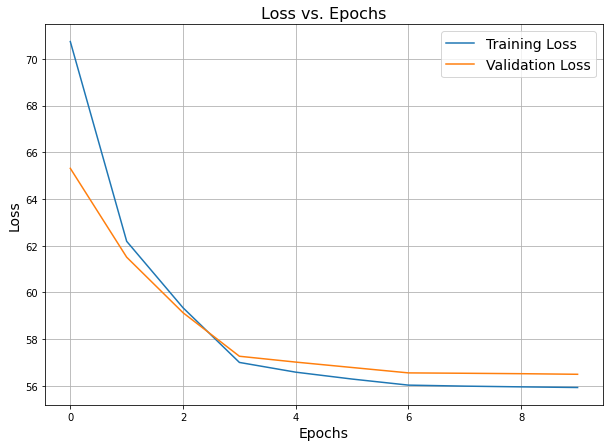

In [9]:
# Plot train and validation loss
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(train_loss, label='Training Loss')
ax.plot(val_loss, label='Validation Loss')
ax.set_title('Loss vs. Epochs', fontsize=16)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend(fontsize=14)
ax.grid(True)
plt.show()

## 8. Meature model performance

In edge detection world, there are two industry standard metrics to measure model performance. The first one is referred as optimal dataset scale (ODS) which employs a fixed threshold for all images in a dataset. The second is called optimal image scale (OIS) which selects an optimal threshold for each image. For the two metrics, the higher the better.

In [10]:
from edges_eval_dir import edges_eval_dir
edges_eval_dir(test_pre, test_gt)

Copy eval_bdry.txt to root_dir and rename it to eval_bdry_rcf.txt. The job is done. The model performance will be compared in Edge Detection enhanced RCF.ipynb.